# HW5

---

#### Name: 吳原博
#### Student ID: 0816004

---

In [69]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split,GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import *
from sklearn import preprocessing
import csv

# Data Input

In [4]:
with open("train.json","r") as file:
  train = json.load(file)
with open("test.json","r") as file:
  test = json.load(file)

# Data  Visualization
我使用 matplotlib 繪製圖表，材料的數量有先排序後再呈現出來，方便了解資料分布

### value count of labels

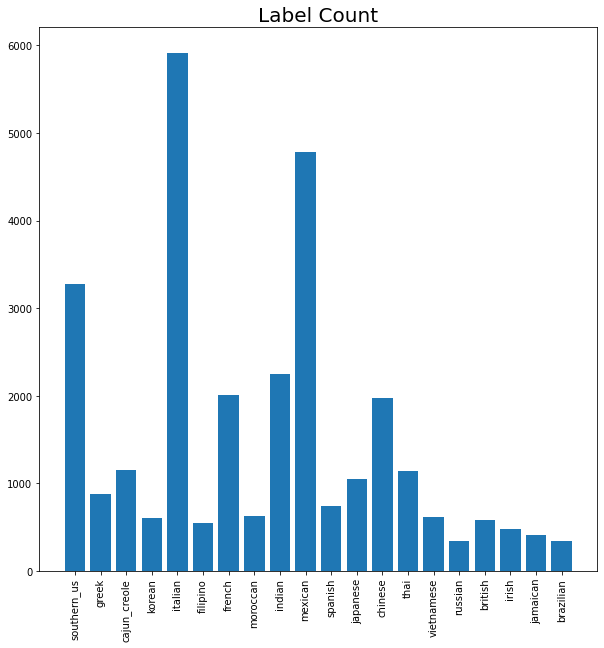

In [ ]:
# value count of labels
count = {}
for i in range(len(train)):
  count[train[i]["cuisine"]] = count.setdefault(train[i]["cuisine"],0) + 1
x_cord = np.arange(len(count.keys()))

plt.figure(figsize=(10,10))
plt.bar(x_cord,count.values())
plt.xticks(x_cord,count.keys(),rotation=90)
plt.title("Label Count",fontsize=20)
plt.show()

### value count of top 30 features

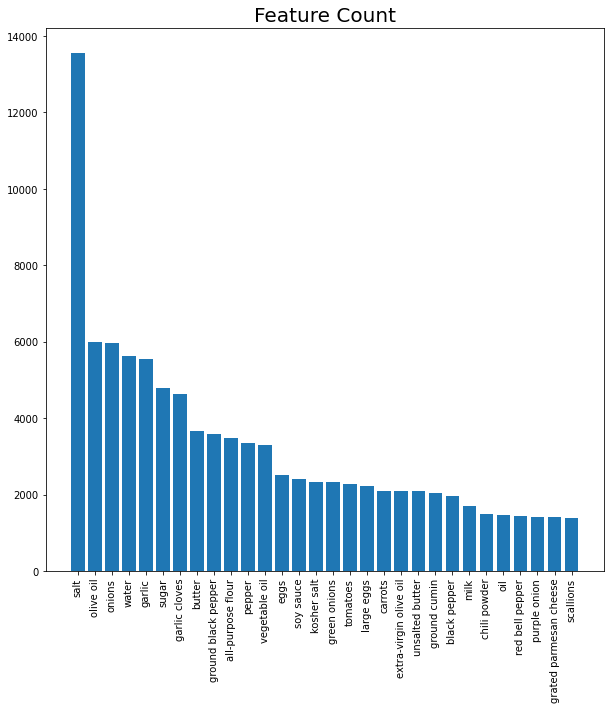

In [ ]:
# value count of top 30 features
count = {}
for i in range(len(train)):
  for food in train[i]["ingredients"]:
    count[food] = count.setdefault(food,0) + 1
count = sorted(count.items(),key=lambda d:d[1],reverse=True)
count = count[0:30]
x_cord = np.arange(len(count))

plt.figure(figsize=(10,10))
plt.xticks(x_cord,np.array(count).T[0],rotation=90)
plt.bar(x_cord,[i[1] for i in count])
plt.title("Feature Count",fontsize=20)
plt.show()



### value count of number of ingredients

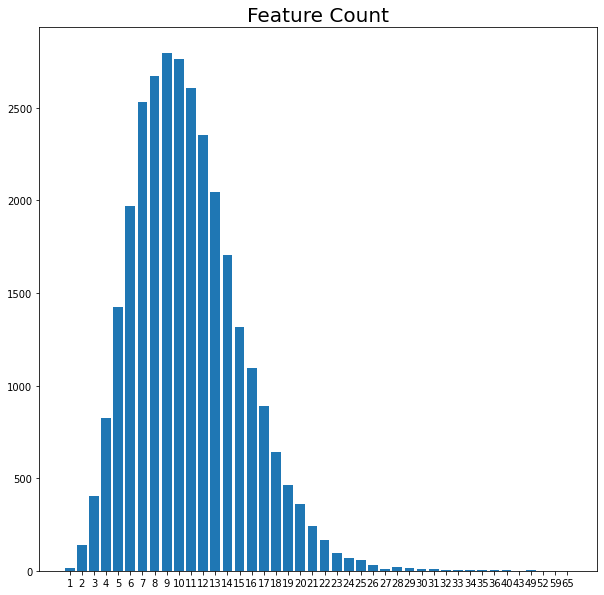

In [ ]:
count = {}
for i in range(len(train)):
  count[len(train[i]["ingredients"])] = count.setdefault(len(train[i]["ingredients"]),0) + 1
count = sorted(count.items(),key=lambda d:d[0])
x_cord = np.arange(len(count))

plt.figure(figsize=(10,10))
plt.xticks(x_cord,[i[0] for i in count])
plt.bar(x_cord,[i[1] for i in count])
plt.title("Feature Count",fontsize=20)
plt.show()

# Data Processing
資料的預處理上，我使用 MultiLabelBinarizer 為材料做編碼，我覺得效果上感覺就像是把所有材料展開成許多的欄位，並且以 0 和 1 做為這些欄位的 feature  
keras 的神經網路模型要求把 label 依照 class 數量展開為對應的維度，因此我使用 one-hot 編碼來處理資料

In [ ]:
mlb = MultiLabelBinarizer()
le = preprocessing.LabelEncoder()
enc = preprocessing.OneHotEncoder()
encoded_x = mlb.fit_transform([train[i]["ingredients"] for i in range(len(train))])
y = [train[i]["cuisine"] for i in range(len(train))]
encoded_y = enc.fit_transform(le.fit_transform(y).reshape(-1,1)).toarray()
x_train, x_val, y_train, y_val = train_test_split(encoded_x, encoded_y, test_size = 0.3)
# one-hot 編碼與其對應的標籤
label = {}
for i in range(len(y)):
  label[np.argmax(encoded_y[i])] = y[i]
encoded_test = mlb.transform([test[i]["ingredients"] for i in range(len(test))])

# ANN

### Model Construction
我的神經網路模型非常單純，基於自己對這方面並不是非常了解，我決定還是簡簡單單的一個輸入家輸出層就好，免得弄巧成拙  
在模型方面，我選擇使用 keras，主要是因為使用起來簡單直覺，並且可以搭配 sklearn 進行調參

In [61]:
def ann_model():
    model = Sequential()
    model.add(Dense(20,input_dim=6213, activation='relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(20,activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

### Training
第一個部分使用 sklearn 的模組進行調參，調參的過程相當的久，雖然我沒有特別用任何加速的方法也大概知道自己設的實驗參數會跑比較久，還是被 3 個多小時的結果嚇了一跳  
老實說我覺得調整 epochs 和 batch size 對模型表現的影響並不是很明顯，但是大致上的確有影響，至少我發現當 epochs 調得太大(一開始我調 100)，accuracy 反而會下降  
也因為調參會很久，我不得不把訓練和預測的部分獨立出來放在下面

In [ ]:
# 調參
model = KerasClassifier(build_fn=ann_model, verbose=0)
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, scoring='accuracy', param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(x_train,y_train)
print(grid.best_params_)
EPOCH = grid.best_params_['epochs']
BATCH = grid.best_params_['batch_size']

In [63]:
estimator = ann_model()
estimator.fit(x_train, y_train, epochs=EPOCH, batch_size=BATCH)
y_pred = estimator.predict(x_val)
test_pred = estimator.predict(encoded_test)

Epoch 1/10
2085/2085 [==============================] - 6s 3ms/step - loss: 1.4450 - accuracy: 0.6080
Epoch 2/10
2085/2085 [==============================] - 5s 3ms/step - loss: 0.7688 - accuracy: 0.7820
Epoch 3/10
2085/2085 [==============================] - 6s 3ms/step - loss: 0.5780 - accuracy: 0.8344
Epoch 4/10
2085/2085 [==============================] - 6s 3ms/step - loss: 0.4669 - accuracy: 0.8657
Epoch 5/10
2085/2085 [==============================] - 6s 3ms/step - loss: 0.3905 - accuracy: 0.8874
Epoch 6/10
2085/2085 [==============================] - 6s 3ms/step - loss: 0.3332 - accuracy: 0.9041
Epoch 7/10
2085/2085 [==============================] - 6s 3ms/step - loss: 0.2874 - accuracy: 0.9179
Epoch 8/10
2085/2085 [==============================] - 7s 3ms/step - loss: 0.2517 - accuracy: 0.9281
Epoch 9/10
2085/2085 [==============================] - 7s 4ms/step - loss: 0.2221 - accuracy: 0.9372
Epoch 10/10
2085/2085 [==============================] - 6s 3ms/step - loss: 0.197

# Results
可能是因為模型簡單，加上資料複雜，預測的準確率都落在 75% 左右  
其中 italian 和 mexican 的 recall 和 precision score 比較高，我認為是因為兩者的數量比較多

In [64]:
pred = [np.argmax(y_pred[i]) for i in range(len(y_pred))]
val = [np.argmax(y_val[i]) for i in range(len(y_val))]
acc = accuracy_score(pred,val)
rec = recall_score(pred,val,average=None)
prec = precision_score(pred,val,average=None)
print("accuracy score :", round(acc,5))
print("------------------------------------------")
form = [[round(rec[i],5),round(prec[i],5)] for i in range(len(rec))]
frame = pd.DataFrame(form,columns=["recall score","precision score"],index=[label[i] for i in range(len(label))])
display(frame)
print("------------------------------------------")
matrix = confusion_matrix(pred,val)
frame = pd.DataFrame(matrix,columns=[label[i] for i in range(len(label))],index=[label[i] for i in range(len(label))])
display(frame)

accuracy score : 0.75641
------------------------------------------


,recall score,precision score
brazilian,0.63000,0.54310
british,0.60504,0.41379
cajun_creole,0.72054,0.65046
chinese,0.78956,0.78297
filipino,0.71523,0.62791
french,0.58232,0.56757
greek,0.74661,0.64961
indian,0.83288,0.88456
irish,0.53676,0.55303
italian,0.80355,0.86259


------------------------------------------


,brazilian,british,cajun_creole,chinese,filipino,french,greek,indian,irish,italian,jamaican,japanese,korean,mexican,moroccan,russian,southern_us,spanish,thai,vietnamese
brazilian,63,2,0,0,5,0,1,2,0,1,2,1,0,15,0,0,1,3,2,2
british,0,72,1,2,1,6,1,1,8,4,5,0,0,1,0,4,12,1,0,0
cajun_creole,1,2,214,2,0,5,0,0,0,14,1,0,0,6,0,1,49,2,0,0
chinese,0,1,0,469,11,3,1,3,0,4,0,31,19,6,0,0,6,1,25,14
filipino,3,1,0,7,108,1,0,2,1,0,6,4,3,3,0,0,3,1,4,4
french,3,13,10,4,3,336,7,4,15,99,1,8,1,10,3,7,32,20,1,0
greek,0,1,0,0,0,6,165,7,2,21,0,1,0,0,8,0,7,3,0,0
indian,2,10,1,3,2,5,10,613,2,5,4,24,0,14,13,4,8,2,11,3
irish,0,14,4,0,0,6,0,5,73,10,0,2,0,2,1,4,13,1,1,0
italian,4,12,18,7,4,134,46,8,10,1538,2,6,1,29,6,10,39,35,2,3


# Kaggle Submission
下面兩個區塊分別是把結果匯出成 csv 檔和把截圖印出來的程式碼。第一次交取得了61名的成績，實在不算是太好XD

In [74]:
path = "out.csv"
kaggle_pred = [np.argmax(test_pred[i]) for i in range(len(test_pred))]
with open(path,'w',newline='') as file:
  writer = csv.writer(file)
  writer.writerow(['id','Category'])
  for i in range(len(kaggle_pred)):
    writer.writerow([test[i]["id"],label[kaggle_pred[i]]])

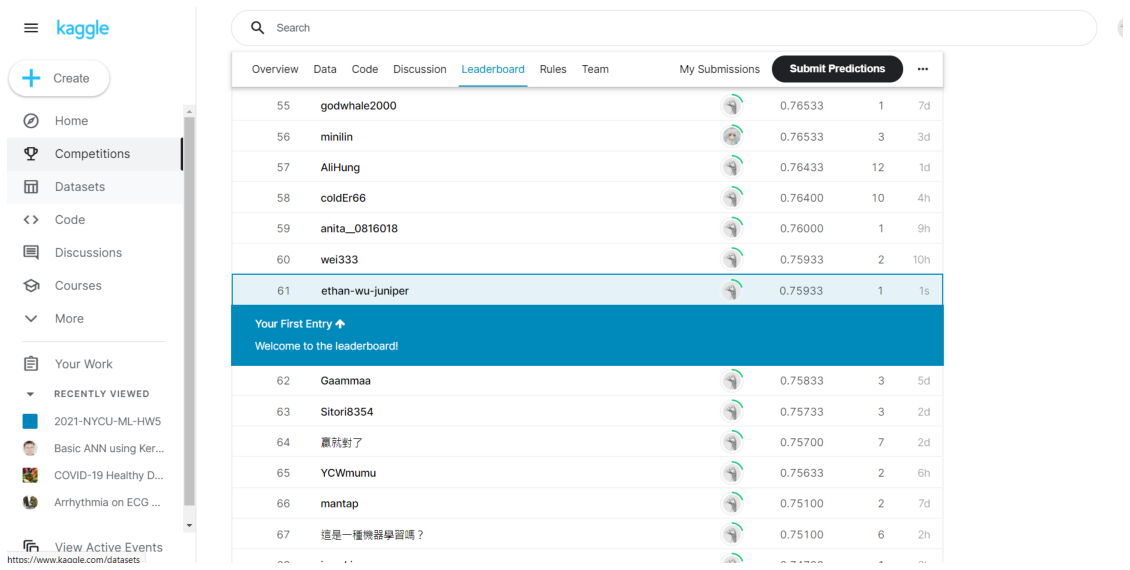

In [77]:
import matplotlib.image as mpimg
img = mpimg.imread('kaggle_submission.png')
plt.figure(figsize=(20,40))
plt.imshow(img)
plt.axis('off')
plt.show()

# Comparison & Conclusion
由於期末課業繁忙，我並沒有花許多心思在優化模型的表現，而只是做簡單的參數調整並且匆匆完成要求，自己覺得有點可惜。不過由於我對神經網路並不熟悉，因此其實就算有時間我可能也不清楚要怎麼提升模型的效果，希望這次作業結束後，可以好好了解其他大神在這次作業上下了什麼樣的功夫。